In [18]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [21]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [22]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [23]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [24]:
len(dataset)

68

In [25]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 1 1 1 0 1 2 1 0 1 0 1 0 0 1 0 0 1 0 1 1 1 1 2 0 0 0 1 1 1]


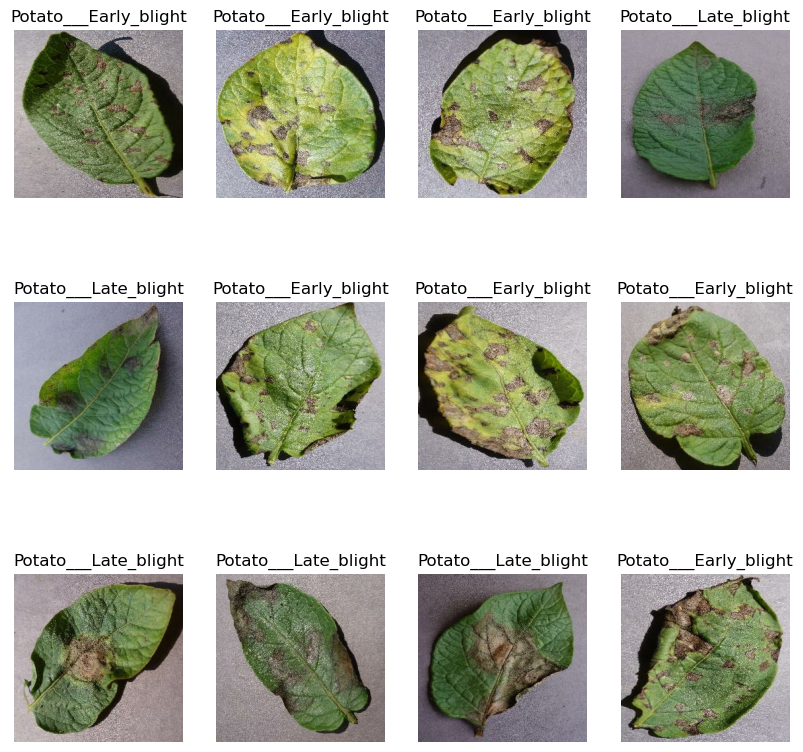

In [26]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
    #plt.imshow(image_batch[0].numpy().astype("uint8"))
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
        #print(image_batch[i].shape)

# Actual length of the dataset is 68 * 32
# Using the holdout method, considering 80% dataset as training and 10% dataset Validation and 10% as test dataset

In [27]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [28]:
train_ds = dataset.take(54)
len(train_ds)

54

In [29]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [30]:
validation_size = 0.1
len(dataset)*validation_size

6.800000000000001

In [31]:
validation_ds = test_ds.take(6)
len(validation_ds)

6

In [32]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [33]:
def get_dataset_partitions_tf(ds, train_split = 0.8, validation_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split*ds_size)
    validation_size = int(validation_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    validation_ds = ds.skip(train_size).take(validation_size)
    test_ds = ds.skip(train_size).skip(validation_size)
    
    return train_ds, validation_ds, test_ds

In [34]:
train_ds, validation_ds, test_ds = get_dataset_partitions_tf(dataset)

In [35]:
len(train_ds)

54

In [36]:
len(validation_ds)

6

In [37]:
len(test_ds)

8

# Caching

In [38]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [39]:
resize_and_rescale = tf.keras.Sequential([
    
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

In [40]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Convolutional Neural Network

In [41]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale, 
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
    
])

model.build(input_shape = input_shape)

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [43]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [44]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = validation_ds
)

Epoch 1/30
54/54 [==============================] - 37s 672ms/step - loss: 0.9196 - accuracy: 0.4716 - val_loss: 0.8446 - val_accuracy: 0.4740
Epoch 2/30
54/54 [==============================] - 33s 609ms/step - loss: 0.7297 - accuracy: 0.6296 - val_loss: 0.6075 - val_accuracy: 0.7552
Epoch 3/30
54/54 [==============================] - 32s 586ms/step - loss: 0.5195 - accuracy: 0.7795 - val_loss: 0.4399 - val_accuracy: 0.7969
Epoch 4/30
54/54 [==============================] - 32s 586ms/step - loss: 0.3631 - accuracy: 0.8513 - val_loss: 0.4254 - val_accuracy: 0.8073
Epoch 5/30
54/54 [==============================] - 32s 593ms/step - loss: 0.2252 - accuracy: 0.9190 - val_loss: 0.3608 - val_accuracy: 0.8542
Epoch 6/30
54/54 [==============================] - 32s 587ms/step - loss: 0.2574 - accuracy: 0.9039 - val_loss: 0.3771 - val_accuracy: 0.8646
Epoch 7/30
54/54 [==============================] - 32s 587ms/step - loss: 0.1546 - accuracy: 0.9456 - val_loss: 0.3740 - val_accuracy: 0.8698

In [45]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 158ms/step - loss: 0.0397 - accuracy: 0.9922


In [46]:
scores #parameter1 = loss, parameter2 = accuracy

[0.03967823460698128, 0.9921875]

In [47]:
history

In [48]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [49]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [50]:
history.history['accuracy']

[0.47164350748062134,
 0.6296296119689941,
 0.7795138955116272,
 0.8512731194496155,
 0.9189814925193787,
 0.9039351940155029,
 0.9456018805503845,
 0.9456018805503845,
 0.9612268805503845,
 0.9577546119689941,
 0.9693287014961243,
 0.9456018805503845,
 0.9704861044883728,
 0.9519675970077515,
 0.9716435074806213,
 0.9652777910232544,
 0.9751157164573669,
 0.9884259104728699,
 0.9872685074806213,
 0.9826388955116272,
 0.9872685074806213,
 0.9739583134651184,
 0.9849537014961243,
 0.9768518805503845,
 0.9785879850387573,
 0.9751157164573669,
 0.9658564925193787,
 0.9837962985038757,
 0.9913194179534912,
 0.9913194179534912]

In [51]:
acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

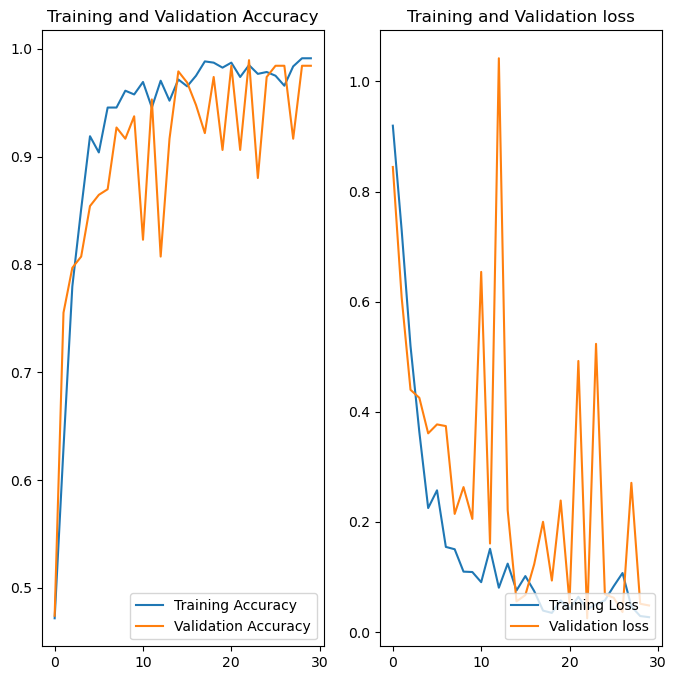

In [52]:
plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), validation_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

#plt.figure(figsize = (8,8))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), validation_loss, label = 'Validation loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation loss')

First image to predict
Actual Label:  Potato___Early_blight
1/1 [==============================] - 0s 267ms/step
Predicted Label:  Potato___Early_blight


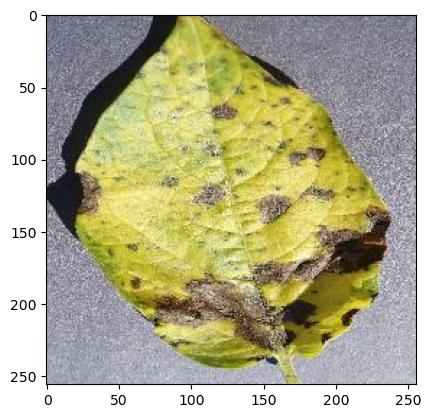

In [53]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label: ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label: ", class_names[np.argmax(batch_prediction[0])])

In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # creating a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


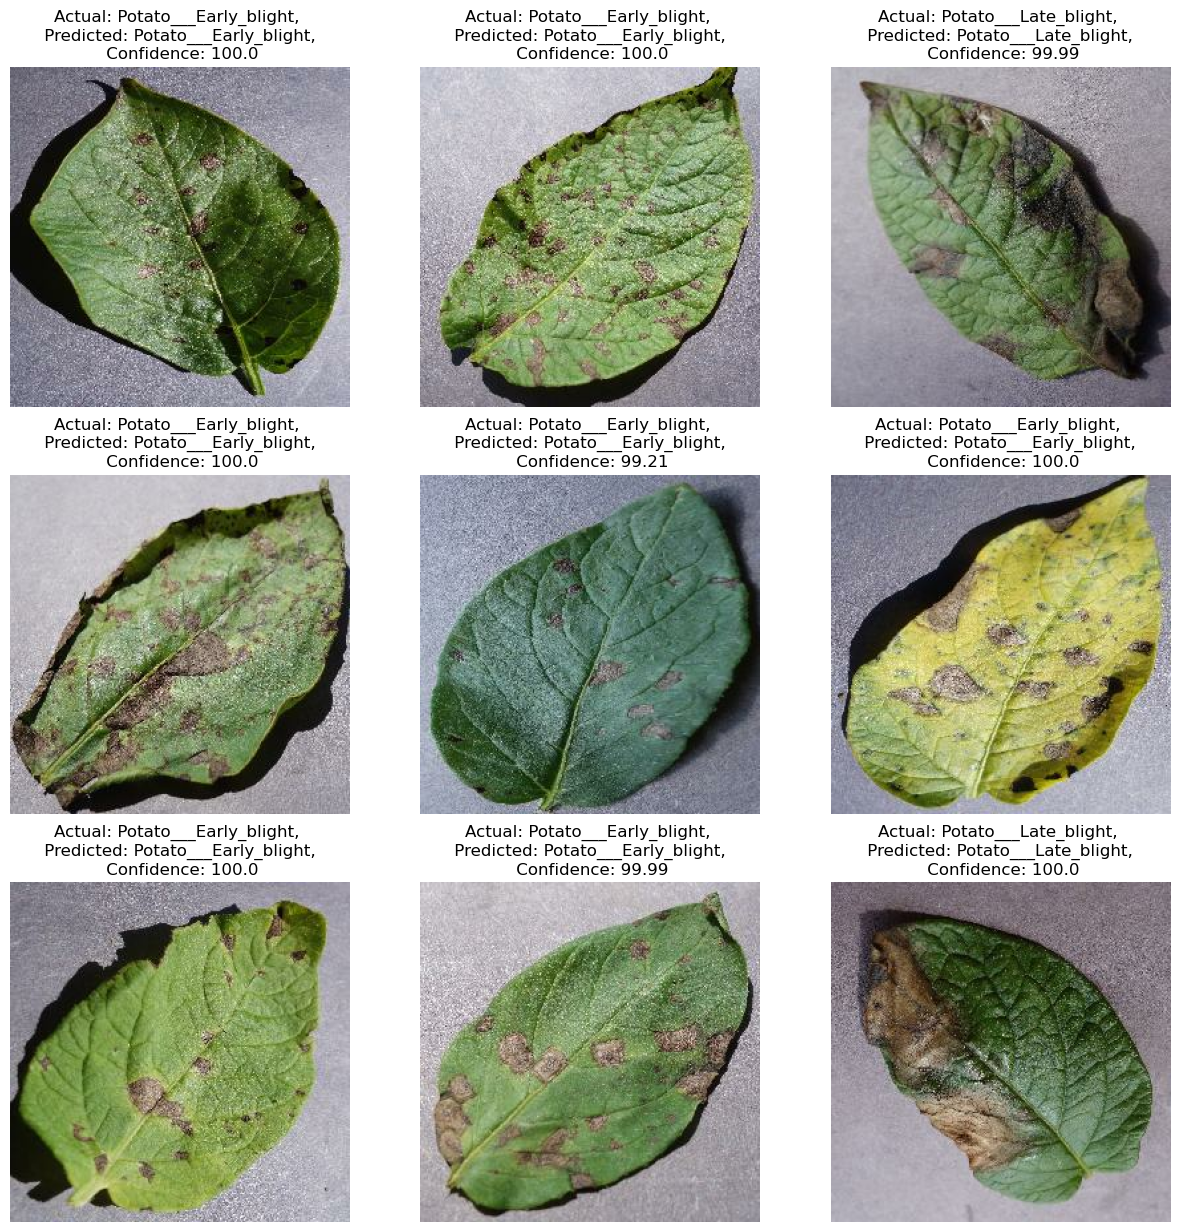

In [55]:
plt.figure(figsize = (15,15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}")
        #plt.title(f"Predicted: {predicted_class}")
        #plt.title(f"Confidence: {confidence}")
        
        
        plt.axis('off')

In [56]:
model.save("potato_leaf_detection.h5")

/Users/karthikkolli/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
